# EV Charging Planner: User Clustering and Uncertainty Assignment

This notebook performs clustering on vehicle/driver data to identify user groups and assigns a standard deviation (STD) of punctuality to each group based on their characteristics.

In [ ]:
# # EV Charging Planner: User Clustering and Uncertainty Assignment
#
# This notebook performs clustering on vehicle/driver data to identify user groups and assigns a standard deviation (STD) of punctuality to each group based on their characteristics.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

# =======================
# 1. Load CSV
# =======================
# Loads the vehicle data from a CSV file into a pandas DataFrame.
df = pd.read_csv("vehicles_extended.csv")

# =======================
# 2. Feature Engineering
# =======================
# Creates new features relevant for clustering and uncertainty assessment.
# - battery_level: Current charge normalized by battery capacity.
# - window_length: Duration of the available charging window.
# - required_energy: Energy needed to reach full charge.
# - required_time: Time needed to charge to full capacity.
# - stress_index: Ratio of required charging time to available window (higher indicates more stress/less flexibility).
# - time_of_day: Categorical representation of the start time (night, morning, afternoon, evening).

# Battery level (normalized)
df["battery_level"] = df["current_charge"] / df["battery_capacity"]

# Charging window length
df["window_length"] = df["available_time_end"] - df["available_time_start"]

# Required energy (to full charge)
df["required_energy"] = df["battery_capacity"] - df["current_charge"]

# Required charging time
df["required_time"] = df["required_energy"] / df["charge_speed"]

# Stress index = required_time / available window (capped to avoid inf)
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

# Time of day (categorical buckets)
def map_time(hour):
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "evening"

df["time_of_day"] = df["available_time_start"].apply(map_time)

# =======================
# 3. Select features for clustering
# =======================
# Defines the features to be used in the clustering process.
features = ["driver_age", "driver_profession", "use_frequency",
            "battery_level", "stress_index", "time_of_day", "origin_distance"]

X = df[features].copy()

# One-hot encode categorical vars (updated for sklearn >=1.2)
encoder = OneHotEncoder(drop="first", sparse_output=False)
categorical = X[["driver_profession", "time_of_day"]]
encoded = encoder.fit_transform(categorical)

# Numeric vars
numeric = X.drop(columns=["driver_profession", "time_of_day"]).values

# Combine
X_proc = np.hstack([numeric, encoded])

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_proc)

# =======================
# 4. KMeans clustering
# =======================
# Applies KMeans clustering to group users based on the selected features.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# =======================
# 5. Assign STD per cluster
# =======================
# Assigns a standard deviation (STD) value to each cluster based on
# heuristic rules derived from the cluster's characteristics (mean frequency, distance, stress).
std_mapping = {}

for cluster in df["cluster"].unique():
    cluster_data = df[df["cluster"] == cluster]
    avg_freq = cluster_data["use_frequency"].mean()
    avg_dist = cluster_data["origin_distance"].mean()
    avg_stress = cluster_data["stress_index"].mean()

    # Heuristic: stable users = low STD, variable users = high STD
    if avg_freq > 4 and avg_stress < 1.0 and avg_dist < 15:
        std = 0.25  # very predictable
    elif avg_freq < 3 or avg_stress > 2.0 or avg_dist > 20:
        std = 1.0   # uncertain users
    else:
        std = 0.5   # medium variability

    std_mapping[cluster] = std

df["assigned_std"] = df["cluster"].map(std_mapping)

# =======================
# 6. Save results
# =======================
# Saves the original DataFrame with the new 'cluster' and 'assigned_std' columns to a CSV file.
df.to_csv("vehicles_clustered.csv", index=False)

print("Clustering done ✅")
print("Assigned STD per cluster:", std_mapping)

Clustering done ✅
Assigned STD per cluster: {np.int32(1): 1.0, np.int32(0): 1.0, np.int32(2): 1.0}


# EV Charging Planner: User Clustering, Uncertainty Assignment and Visualization

This notebook performs user clustering, assigns a standard deviation (STD) of punctuality to each group, and visualizes the clusters using PCA.

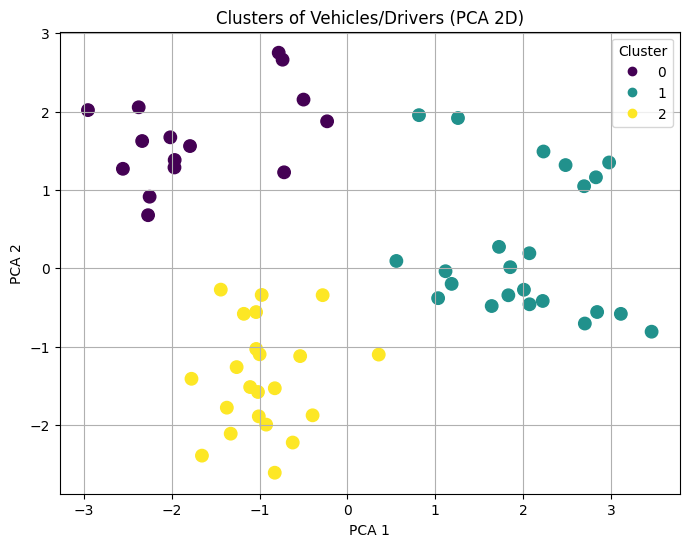

Clustering + visualization done ✅
Assigned STD per cluster: {0: 0.25, 1: 0.5, 2: 1.0}


In [ ]:
# # EV Charging Planner: User Clustering, Uncertainty Assignment and Visualization
#
# This notebook performs user clustering, assigns a standard deviation (STD) of punctuality to each group, and visualizes the clusters using PCA.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# =======================
# 1. Load CSV
# =======================
# Loads the vehicle data from a CSV file into a pandas DataFrame.
df = pd.read_csv("vehicles_extended.csv")

# =======================
# 2. Feature Engineering
# =======================
# Creates new features relevant for clustering and uncertainty assessment.
# - battery_level: Current charge normalized by battery capacity.
# - window_length: Duration of the available charging window.
# - required_energy: Energy needed to reach full charge.
# - required_time: Time needed to charge to full capacity.
# - stress_index: Ratio of required charging time to available window (higher indicates more stress/less flexibility).
# - time_of_day: Categorical representation of the start time (night, morning, afternoon, evening).
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

def map_time(hour):
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "evening"

df["time_of_day"] = df["available_time_start"].apply(map_time)

# =======================
# 3. Prepare features for clustering
# =======================
# Selects features for clustering and applies one-hot encoding and standardization.
features = ["driver_age", "driver_profession", "use_frequency",
            "battery_level", "stress_index", "time_of_day", "origin_distance"]

X = df[features].copy()
encoder = OneHotEncoder(drop="first", sparse_output=False)
categorical = X[["driver_profession", "time_of_day"]]
encoded = encoder.fit_transform(categorical)
numeric = X.drop(columns=["driver_profession", "time_of_day"]).values
X_proc = np.hstack([numeric, encoded])
X_scaled = StandardScaler().fit_transform(X_proc)

# =======================
# 4. KMeans clustering
# =======================
# Performs KMeans clustering with 3 clusters.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# =======================
# 5. Assign fixed STD per cluster
# =======================
# Assigns predefined standard deviation (STD) values to each cluster.
# Asignamos directamente una std distinta a cada cluster
std_mapping = {
    0: 0.25,  # Cluster 0 (e.g., punctual)
    1: 0.5,   # Cluster 1 (e.g., medium variability)
    2: 1.0    # Cluster 2 (e.g., unpunctual)
}

df["assigned_std"] = df["cluster"].map(std_mapping)

# =======================
# 6. PCA para visualización
# =======================
# Applies Principal Component Analysis (PCA) to reduce the dimensionality for visualization and plots the clusters.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="viridis", s=80)
plt.title("Clusters of Vehicles/Drivers (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()

# =======================
# 7. Save results
# =======================
# Saves the DataFrame with cluster assignments and assigned STDs to a new CSV file.
df.to_csv("vehicles_clustered_with_std.csv", index=False)
print("Clustering + visualization done ✅")
print("Assigned STD per cluster:", std_mapping)

# Simulation: Impact of Uncertainty on EV Charging Planning

This notebook simulates the impact of different levels of user punctuality uncertainty (represented by standard deviation, σ) on EV charging planning metrics like total cost and timespan.

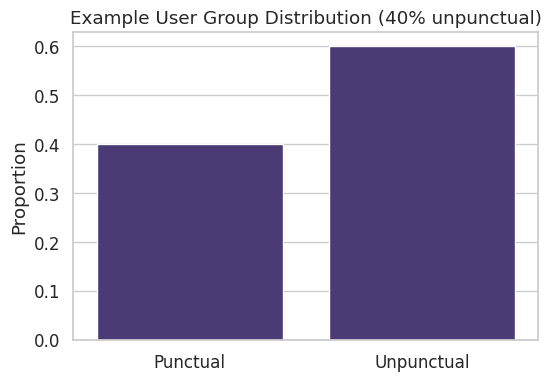

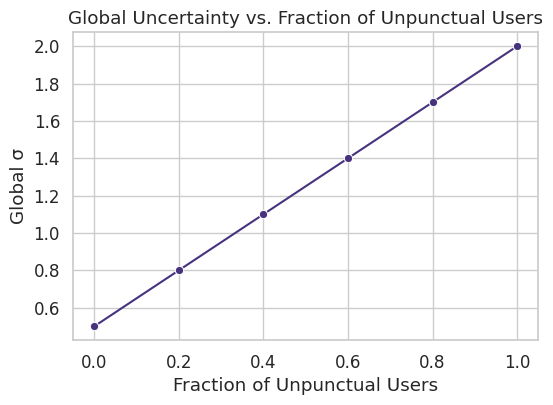

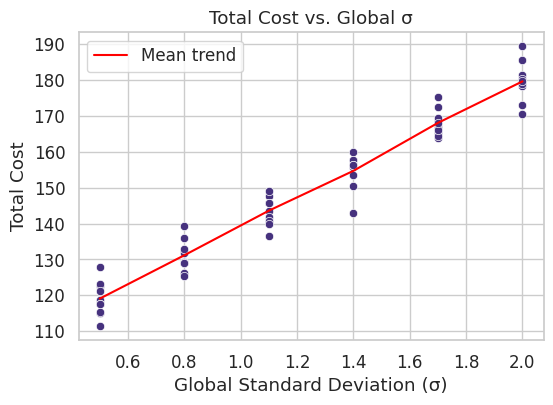

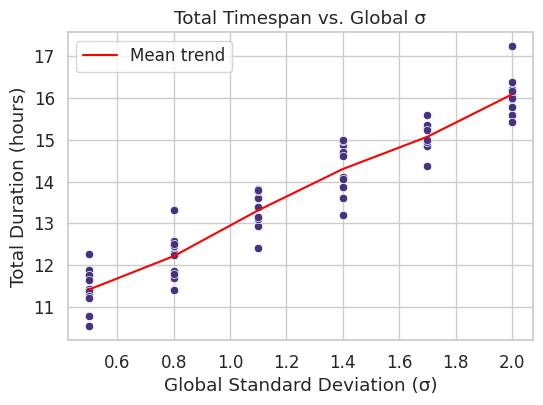

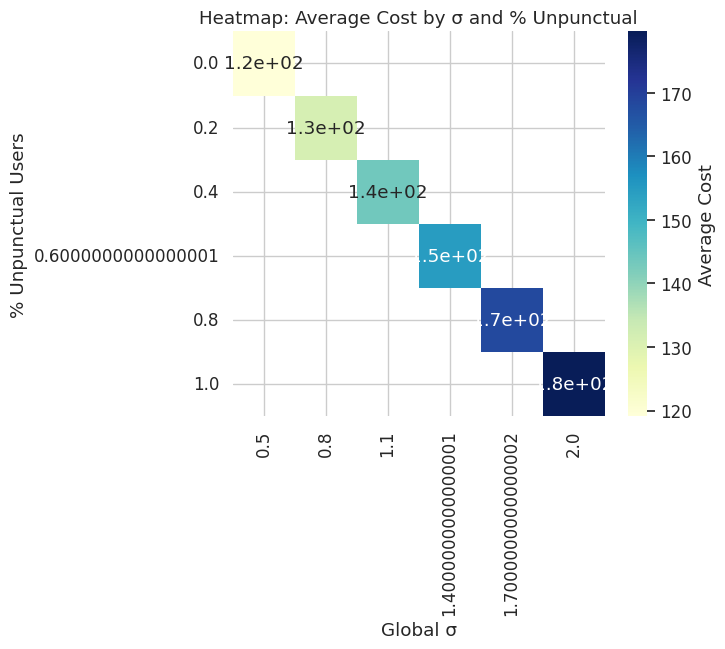

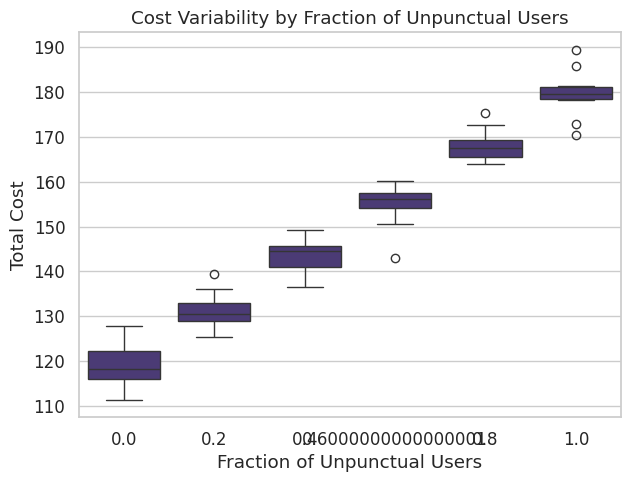

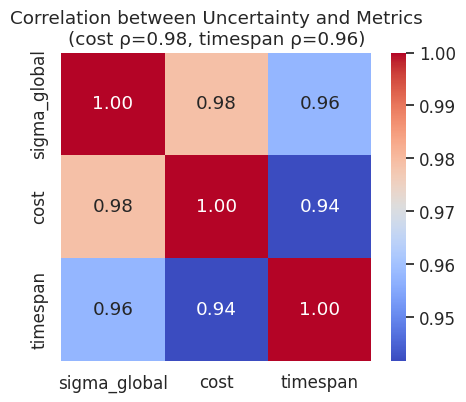

In [ ]:
# # Simulation: Impact of Uncertainty on EV Charging Planning
#
# This notebook simulates the impact of different levels of user punctuality uncertainty (represented by standard deviation, σ) on EV charging planning metrics like total cost and timespan.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# General style
sns.set(style="whitegrid", palette="viridis", font_scale=1.1)

# -----------------------------
# 1. Synthetic Data Generation
# -----------------------------
# Generates synthetic data to simulate different scenarios of user punctuality and their impact on charging outcomes.
np.random.seed(42)

# Scenarios: percentage of unpunctual users (high σ)
unpunctual_pct = np.linspace(0, 1, 6)  # 0%, 20%, ..., 100%
sigma_punctual = 0.5
sigma_unpunctual = 2.0

data = []

for p in unpunctual_pct:
    # Weighted global sigma (population-level uncertainty)
    sigma_global = (1 - p) * sigma_punctual + p * sigma_unpunctual

    # Simulate 10 independent runs per scenario
    for _ in range(10):
        # Add realistic random noise
        cost = 100 + 40 * sigma_global + np.random.normal(0, 5)
        timespan = 10 + 3 * sigma_global + np.random.normal(0, 0.5)
        data.append([p, sigma_global, cost, timespan])

df = pd.DataFrame(data, columns=["pct_unpunctual", "sigma_global", "cost", "timespan"])

# -----------------------------
# 2. Figure 1: Example Group Distribution
# -----------------------------
# Visualizes an example distribution of punctual and unpunctual user groups.
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=["Punctual", "Unpunctual"], y=[1 - unpunctual_pct[3], unpunctual_pct[3]], ax=ax)
ax.set_title("Example User Group Distribution (40% unpunctual)")
ax.set_ylabel("Proportion")
plt.show()

# -----------------------------
# 3. Figure 2: Global σ vs % Unpunctual
# -----------------------------
# Plots the relationship between the global uncertainty (σ) and the fraction of unpunctual users.
plt.figure(figsize=(6,4))
sns.lineplot(x=unpunctual_pct,
             y=(1 - unpunctual_pct) * sigma_punctual + unpunctual_pct * sigma_unpunctual,
             marker="o")
plt.title("Global Uncertainty vs. Fraction of Unpunctual Users")
plt.xlabel("Fraction of Unpunctual Users")
plt.ylabel("Global σ")
plt.show()

# -----------------------------
# 4. Figure 3: Cost vs Global σ
# -----------------------------
# Shows the relationship between total charging cost and global uncertainty (σ).
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="sigma_global", y="cost")
sns.lineplot(data=df.groupby("sigma_global")["cost"].mean().reset_index(),
             x="sigma_global", y="cost", color="red", label="Mean trend")
plt.title("Total Cost vs. Global σ")
plt.xlabel("Global Standard Deviation (σ)")
plt.ylabel("Total Cost")
plt.legend()
plt.show()

# -----------------------------
# 5. Figure 4: Timespan vs Global σ
# -----------------------------
# Shows the relationship between total charging timespan and global uncertainty (σ).
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="sigma_global", y="timespan")
sns.lineplot(data=df.groupby("sigma_global")["timespan"].mean().reset_index(),
             x="sigma_global", y="timespan", color="red", label="Mean trend")
plt.title("Total Timespan vs. Global σ")
plt.xlabel("Global Standard Deviation (σ)")
plt.ylabel("Total Duration (hours)")
plt.legend()
plt.show()

# -----------------------------
# 6. Figure 5: Heatmap (σ vs % Unpunctual → Avg. Cost)
# -----------------------------
# Displays a heatmap showing the average cost based on the fraction of unpunctual users and global uncertainty (σ).
heat_df = df.groupby(["pct_unpunctual", "sigma_global"]).mean(numeric_only=True).reset_index()
pivot = heat_df.pivot(index="pct_unpunctual", columns="sigma_global", values="cost")

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Cost'})
plt.title("Heatmap: Average Cost by σ and % Unpunctual")
plt.xlabel("Global σ")
plt.ylabel("% Unpunctual Users")
plt.show()

# -----------------------------
# 7. Figure 6: Boxplot per Scenario
# -----------------------------
# Shows the variability of total cost for each scenario (fraction of unpunctual users) using a boxplot.
plt.figure(figsize=(7,5))
sns.boxplot(x="pct_unpunctual", y="cost", data=df)
plt.title("Cost Variability by Fraction of Unpunctual Users")
plt.xlabel("Fraction of Unpunctual Users")
plt.ylabel("Total Cost")
plt.show()

# -----------------------------
# 8. Figure 7: Correlation Matrix (σ vs Metrics)
# -----------------------------
# Displays a heatmap showing the correlation between global uncertainty (σ), cost, and timespan.
corr_cost = df["sigma_global"].corr(df["cost"])
corr_time = df["sigma_global"].corr(df["timespan"])

plt.figure(figsize=(5,4))
sns.heatmap(df[["sigma_global", "cost", "timespan"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation between Uncertainty and Metrics\n(cost ρ={corr_cost:.2f}, timespan ρ={corr_time:.2f})")
plt.show()

# Simulation: Impact of Uncertainty on EV Charging Planning (Refined Scenarios)

This notebook refines the simulation of uncertainty's impact on EV charging planning, defining more realistic scenarios with varying fractions of unpunctual users and analyzing the effects on cost and timespan.

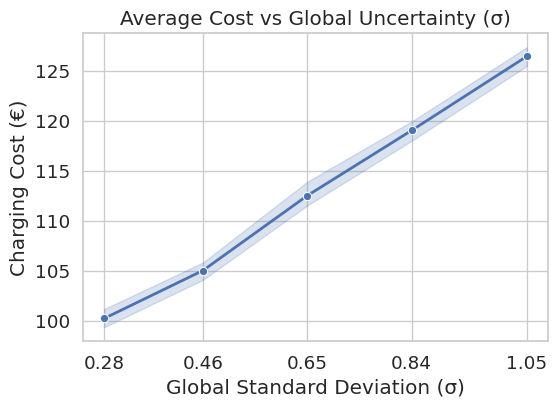

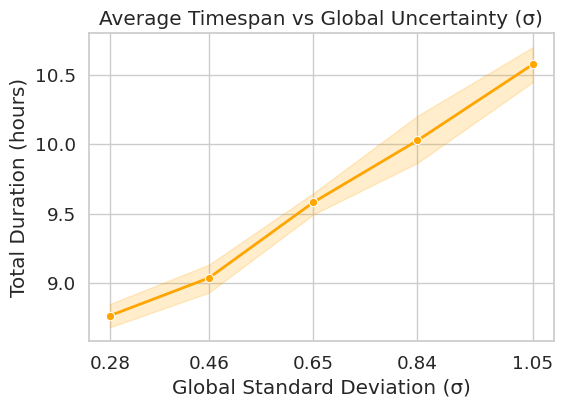

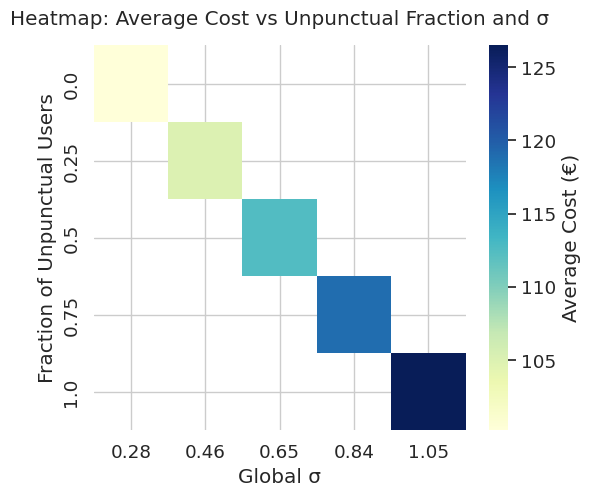

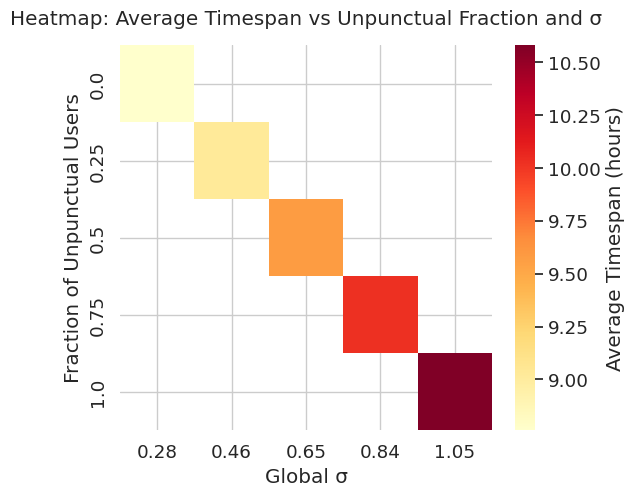

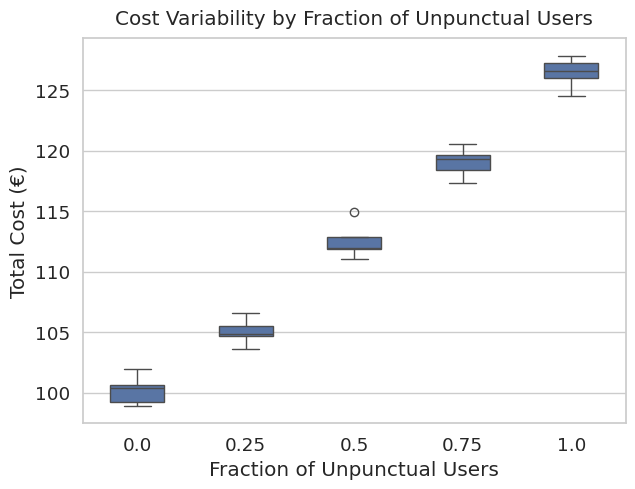

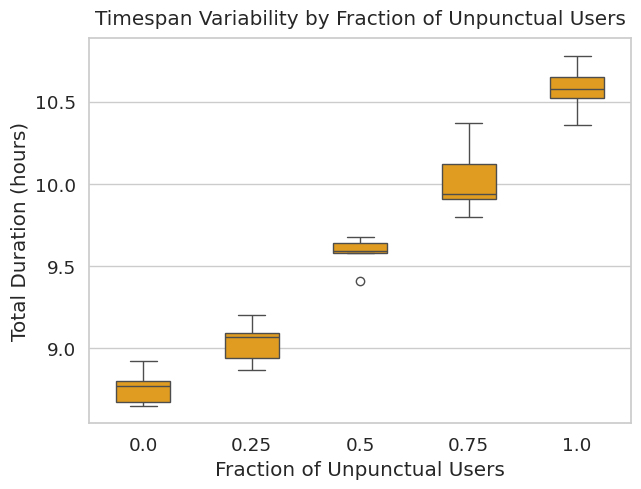

Correlation σ–Cost: 0.99 | σ–Timespan: 0.98


In [ ]:
# # Simulation: Impact of Uncertainty on EV Charging Planning (Refined Scenarios)
#
# This notebook refines the simulation of uncertainty's impact on EV charging planning, defining more realistic scenarios with varying fractions of unpunctual users and analyzing the effects on cost and timespan.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="deep", font_scale=1.2)
np.random.seed(42)

# ---------------------------------
# 1. Define realistic scenarios
# ---------------------------------
# Defines different levels of user punctuality uncertainty (σ) and fractions of users in the high-uncertainty group to create realistic simulation scenarios.
# Three uncertainty levels for user punctuality
sigma_levels = [0.25, 0.5, 1.0]   # punctual → unpunctual
labels = ["Low σ (punctual)", "Medium σ", "High σ (unpunctual)"]

# Fractions of users in the high-σ group
fractions = [0.0, 0.25, 0.5, 0.75, 1.0]  # 0% → 100% unpunctual

data = []

for frac_high in fractions:
    frac_med = 0.1
    frac_low = 1 - frac_high - frac_med
    if frac_low < 0:
        frac_low = 0

    # Weighted global σ (can reach ~1.05)
    sigma_global = (frac_low * sigma_levels[0] +
                    frac_med * sigma_levels[1] +
                    frac_high * sigma_levels[2])

    # Simulated performance metrics
    cost_mean = 90 + 35 * sigma_global        # higher σ → higher cost
    timespan_mean = 8 + 2.5 * sigma_global    # higher σ → longer total duration

    # Add small random variability
    for _ in range(5):
        cost = np.random.normal(cost_mean, 1.5)
        time = np.random.normal(timespan_mean, 0.15)
        data.append([frac_high, sigma_global, cost, time])

df = pd.DataFrame(data, columns=["frac_unpunctual", "sigma_global", "cost", "timespan"])
df = df.round(2)

# ---------------------------------
# 2. Cost vs σ_global
# ---------------------------------
# Plots the average charging cost against the global uncertainty (σ).
plt.figure(figsize=(6,4))
sns.lineplot(data=df, x="sigma_global", y="cost", marker="o", lw=2)
plt.title("Average Cost vs Global Uncertainty (σ)")
plt.xlabel("Global Standard Deviation (σ)")
plt.ylabel("Charging Cost (€)")
plt.xticks(sorted(df['sigma_global'].unique()))
plt.show()

# ---------------------------------
# 3. Timespan vs σ_global
# ---------------------------------
# Plots the average total timespan against the global uncertainty (σ).
plt.figure(figsize=(6,4))
sns.lineplot(data=df, x="sigma_global", y="timespan", marker="o", lw=2, color="orange")
plt.title("Average Timespan vs Global Uncertainty (σ)")
plt.xlabel("Global Standard Deviation (σ)")
plt.ylabel("Total Duration (hours)")
plt.xticks(sorted(df['sigma_global'].unique()))
plt.show()

# ---------------------------------
# 4. Heatmap: Average Cost
# ---------------------------------
# Displays a heatmap showing the average cost based on the fraction of unpunctual users and global uncertainty (σ).
heat_df = df.groupby(["frac_unpunctual", "sigma_global"]).mean(numeric_only=True).reset_index()
pivot_cost = heat_df.pivot(index="frac_unpunctual", columns="sigma_global", values="cost")

plt.figure(figsize=(6,5))
sns.heatmap(pivot_cost.round(1), annot=False, cmap="YlGnBu",
            cbar_kws={'label': 'Average Cost (€)'})
plt.title("Heatmap: Average Cost vs Unpunctual Fraction and σ", pad=15)
plt.xlabel("Global σ")
plt.ylabel("Fraction of Unpunctual Users")
plt.show()

# ---------------------------------
# 5. Heatmap: Average Timespan
# ---------------------------------
# Displays a heatmap showing the average timespan based on the fraction of unpunctual users and global uncertainty (σ).
pivot_time = heat_df.pivot(index="frac_unpunctual", columns="sigma_global", values="timespan")

plt.figure(figsize=(6,5))
sns.heatmap(pivot_time.round(2), annot=False, cmap="YlOrRd",
            cbar_kws={'label': 'Average Timespan (hours)'})
plt.title("Heatmap: Average Timespan vs Unpunctual Fraction and σ", pad=15)
plt.xlabel("Global σ")
plt.ylabel("Fraction of Unpunctual Users")
plt.show()

# ---------------------------------
# 6. Boxplot per scenario (costs)
# ---------------------------------
# Shows the variability of total charging cost for each scenario (fraction of unpunctual users) using a boxplot.
plt.figure(figsize=(7,5))
sns.boxplot(x="frac_unpunctual", y="cost", data=df, width=0.5)
plt.title("Cost Variability by Fraction of Unpunctual Users", pad=10)
plt.xlabel("Fraction of Unpunctual Users")
plt.ylabel("Total Cost (€)")
plt.show()

# 6b. Boxplot per scenario (Timespan)
# Shows the variability of total charging timespan for each scenario (fraction of unpunctual users) using a boxplot.
plt.figure(figsize=(7,5))
sns.boxplot(x="frac_unpunctual", y="timespan", data=df, width=0.5, color="orange")
plt.title("Timespan Variability by Fraction of Unpunctual Users", pad=10)
plt.xlabel("Fraction of Unpunctual Users")
plt.ylabel("Total Duration (hours)")
plt.show()

# ---------------------------------
# 7. Correlation summary
# ---------------------------------
# Calculates and prints the correlation between global uncertainty (σ) and the simulated metrics (cost and timespan).
corr_cost = df["sigma_global"].corr(df["cost"])
corr_time = df["sigma_global"].corr(df["timespan"])
print(f"Correlation σ–Cost: {corr_cost:.2f} | σ–Timespan: {corr_time:.2f}")

# EV Charging Planner: User Clustering (Punctual vs Unpunctual) and STD Assignment

This notebook focuses on clustering users into two groups (punctual and unpunctual) based on their characteristics and assigning a standard deviation (STD) of punctuality to each group.

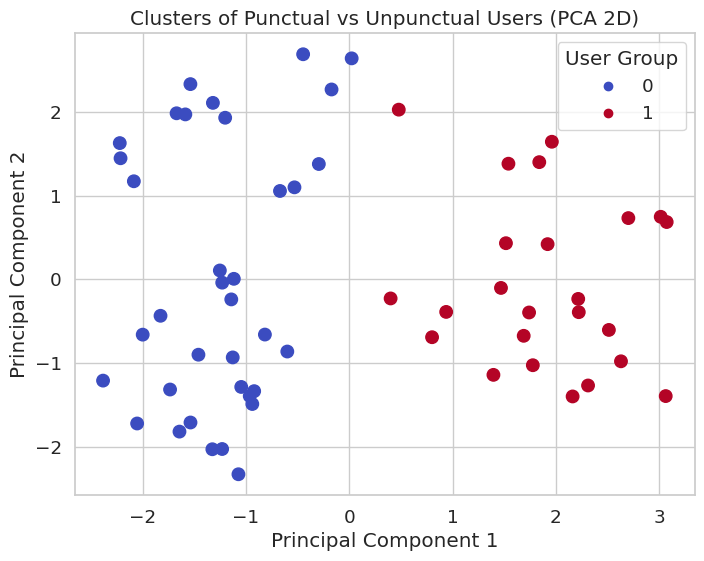

Clustering (punctual vs unpunctual) ✅
Assigned STD per group: {0: 0.25, 1: 0.75}


In [ ]:
# # EV Charging Planner: User Clustering (Punctual vs Unpunctual) and STD Assignment
#
# This notebook focuses on clustering users into two groups (punctual and unpunctual) based on their characteristics and assigning a standard deviation (STD) of punctuality to each group.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# =======================
# 1. Load CSV
# =======================
# Loads the vehicle data from a CSV file into a pandas DataFrame.
df = pd.read_csv("vehicles_precision_3.csv")

# =======================
# 2. Feature Engineering
# =======================
# Creates new features relevant for clustering and uncertainty assessment.
# - battery_level: Current charge normalized by battery capacity.
# - window_length: Duration of the available charging window.
# - required_energy: Energy needed to reach full charge.
# - required_time: Time needed to charge to full capacity.
# - stress_index: Ratio of required charging time to available window (higher indicates more stress/less flexibility).
# - time_of_day: Categorical representation of the start time (night, morning, afternoon, evening).
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

def map_time(hour):
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "evening"

df["time_of_day"] = df["available_time_start"].apply(map_time)

# =======================
# 3. Prepare features for clustering
# =======================
# Selects features for clustering and applies one-hot encoding and standardization.
features = ["driver_age", "driver_profession", "use_frequency",
            "battery_level", "stress_index", "time_of_day", "origin_distance"]

X = df[features].copy()
encoder = OneHotEncoder(drop="first", sparse_output=False)
categorical = X[["driver_profession", "time_of_day"]]
encoded = encoder.fit_transform(categorical)
numeric = X.drop(columns=["driver_profession", "time_of_day"]).values
X_proc = np.hstack([numeric, encoded])
X_scaled = StandardScaler().fit_transform(X_proc)

# =======================
# 4. KMeans clustering (2 groups)
# =======================
# Performs KMeans clustering to divide users into 2 groups, intended to represent punctual and unpunctual users.
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Assign interpretable labels
cluster_names = {0: "punctual", 1: "unpunctual"}
df["user_type"] = df["cluster"].map(cluster_names)

# =======================
# 5. Assign STD per group
# =======================
# Assigns predefined standard deviation (STD) values to the "punctual" and "unpunctual" user groups.
std_mapping = {
    0: 0.25,  # punctual users
    1: 0.75   # unpunctual users
}
df["assigned_std"] = df["cluster"].map(std_mapping)

# =======================
# 6. PCA for visualization
# =======================
# Applies Principal Component Analysis (PCA) to reduce dimensionality for visualization and plots the two user groups.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="coolwarm", s=80)
plt.title("Clusters of Punctual vs Unpunctual Users (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="User Group")
plt.grid(True)
plt.show()

# =======================
# 7. Save results
# =======================
# Saves the DataFrame with cluster assignments and assigned STDs to a new CSV file.
df.to_csv("vehicles_punctuality_clusters.csv", index=False)
print("Clustering (punctual vs unpunctual) ✅")
print("Assigned STD per group:", std_mapping)

# EV Charging Planner: KMeans Parameter Tuning for Clustering Precision

This notebook explores different KMeans clustering parameters (n_init, max_iter, init) to evaluate their impact on clustering precision, measured by the Silhouette Score, using various synthetic datasets with increasing separation.

In [ ]:
# # EV Charging Planner: KMeans Parameter Tuning for Clustering Precision
#
# This notebook explores different KMeans clustering parameters (n_init, max_iter, init) to evaluate their impact on clustering precision, measured by the Silhouette Score, using various synthetic datasets with increasing separation.

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cargar datos
# Loads one of the synthetic datasets generated to test clustering precision.
data = pd.read_csv("vehicles_precision_2.csv")

# Codificar variable categórica 'driver_profession'
# Encodes the categorical feature 'driver_profession' into numerical format for clustering.
le = LabelEncoder()
data["driver_profession"] = le.fit_transform(data["driver_profession"])

# Seleccionar variables relevantes (puedes ajustar las columnas si quieres)
# Selects the features to be used in the clustering analysis.
features = [
    "distance", "available_time_start", "available_time_end", "current_charge",
    "battery_capacity", "charge_speed", "discharge_rate",
    "driver_age", "driver_profession", "use_frequency", "origin_distance"
]

X = data[features]

# Escalar los datos
# Scales the selected features to have zero mean and unit variance, which is important for KMeans.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir experimentos
# Defines a list of dictionaries, where each dictionary represents a KMeans clustering experiment with specific parameter settings.
experiments = [
    {"name": "Very basic (worst)", "n_init": 1, "max_iter": 100, "init": "random", "random_state": None},
    {"name": "Basic stable", "n_init": 10, "max_iter": 200, "init": "k-means++", "random_state": 42},
    {"name": "Medium stability", "n_init": 20, "max_iter": 300, "init": "k-means++", "random_state": 42},
    {"name": "Refined", "n_init": 50, "max_iter": 400, "init": "k-means++", "random_state": 42},
    {"name": "High precision", "n_init": 100, "max_iter": 500, "init": "k-means++", "random_state": 42},
    {"name": "Exploratory (variable)", "n_init": 30, "max_iter": 300, "init": "random", "random_state": 0},
]

results = []

# Ejecutar experimentos
# Iterates through each defined experiment, performs KMeans clustering, calculates the Silhouette Score, and stores the results.
for exp in experiments:
    kmeans = KMeans(
        n_clusters=2,
        n_init=exp["n_init"],
        max_iter=exp["max_iter"],
        init=exp["init"],
        random_state=exp["random_state"]
    )
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    results.append((exp["name"], score))
    print(f"{exp['name']}: Silhouette Score = {score:.4f}")

# Mostrar mejor configuración
# Prints the configuration that yielded the highest Silhouette Score, indicating the best clustering precision among the experiments.
best = max(results, key=lambda x: x[1])
print("\n✅ Best configuration:", best[0], "with Silhouette Score =", round(best[1], 4))

Very basic (worst): Silhouette Score = 0.2161
Basic stable: Silhouette Score = 0.2161
Medium stability: Silhouette Score = 0.2161
Refined: Silhouette Score = 0.2161
High precision: Silhouette Score = 0.2161
Exploratory (variable): Silhouette Score = 0.2161

✅ Best configuration: Very basic (worst) with Silhouette Score = 0.2161


# Data Generation: Synthetic Datasets for Clustering Precision Testing

This notebook generates a series of synthetic datasets (`vehicles_precision_1.csv` to `vehicles_precision_6.csv`) with increasing levels of separation between two user groups (punctual and unpunctual). These datasets are designed to test the performance and precision of clustering algorithms under varying conditions.

In [ ]:
# # Data Generation: Synthetic Datasets for Clustering Precision Testing
#
# This notebook generates a series of synthetic datasets (`vehicles_precision_1.csv` to `vehicles_precision_6.csv`) with increasing levels of separation between two user groups (punctual and unpunctual). These datasets are designed to test the performance and precision of clustering algorithms under varying conditions.

import pandas as pd
import numpy as np

# =======================
# 1. Load original data
# =======================
# Loads the base vehicle data from a CSV file.
df = pd.read_csv("vehicles_extended.csv")

# =======================
# 2. Feature engineering
# =======================
# Creates new features based on the original data.
# - battery_level: Current charge normalized by battery capacity.
# - window_length: Duration of the available charging window.
# - required_energy: Energy needed to reach full charge.
# - required_time: Time needed to charge to full capacity.
# - stress_index: Ratio of required charging time to available window (higher indicates more stress/less flexibility).
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

# =======================
# 3. Base grouping
# =======================
# Creates a base grouping of users into "unpunctual" and "punctual" based on the median of the 'stress_index'.
median_stress = df["stress_index"].median()
df["user_type"] = np.where(df["stress_index"] > median_stress, "unpunctual", "punctual")

# =======================
# 4. Generate 6 datasets with increasing separation
# =======================
# Generates 6 modified datasets. For each dataset, it adds random noise and increases the separation
# between the "unpunctual" and "punctual" groups by multiplying certain features for the unpunctual users.
np.random.seed(42)

# Noise levels for each dataset (higher = harder to classify)
noise_levels = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Separation factors for unpunctual users (higher = more distinct)
separation_factors = [1.0, 1.2, 1.5, 2.0, 3.0, 5.0]

for i in range(6):
    df_mod = df.copy()

    # Añadir ruido proporcional al nivel (más ruido = más difícil)
    # Adds random noise to selected columns, with the level of noise decreasing for higher precision levels.
    noise = noise_levels[i]
    for col in ["current_charge", "charge_speed", "available_time_start", "available_time_end"]:
        scale = df_mod[col].std() * noise
        df_mod[col] += np.random.normal(0, scale, size=len(df_mod))

    # Recalcular dependientes
    # Recalculates the engineered features after adding noise.
    df_mod["battery_level"] = df_mod["current_charge"] / df_mod["battery_capacity"]
    df_mod["window_length"] = df_mod["available_time_end"] - df_mod["available_time_start"]
    df_mod["required_energy"] = df_mod["battery_capacity"] - df_mod["current_charge"]
    df_mod["required_time"] = df_mod["required_energy"] / df_mod["charge_speed"]
    df_mod["stress_index"] = df_mod["required_time"] / df_mod["window_length"].replace(0, 0.5)

    # Aumentar diferencias de los usuarios impuntuales
    # Multiplies the 'stress_index' and 'required_time' for unpunctual users by a separation factor,
    # making them more distinct. The 'window_length' is divided by the same factor, representing tighter windows.
    factor = separation_factors[i]
    df_mod.loc[df_mod["user_type"] == "unpunctual", "stress_index"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "required_time"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "window_length"] *= (1/factor)  # ventanas más ajustadas

    # Guardar CSV
    # Saves the modified DataFrame as a new CSV file.
    filename = f"vehicles_precision_{i+1}.csv"
    df_mod.to_csv(filename, index=False)
    print(f"✅ Saved {filename} (precision level {i+1})")

print("\nDatasets generated from level 1 (very mixed) to level 6 (super distinct).")

✅ Saved vehicles_precision_1.csv (precision level 1)
✅ Saved vehicles_precision_2.csv (precision level 2)
✅ Saved vehicles_precision_3.csv (precision level 3)
✅ Saved vehicles_precision_4.csv (precision level 4)
✅ Saved vehicles_precision_5.csv (precision level 5)
✅ Saved vehicles_precision_6.csv (precision level 6)

Datasets generated from level 1 (very mixed) to level 6 (super distinct).


# Data Generation: Synthetic Datasets with Stronger Separation for Clustering Precision Testing

This notebook generates a series of synthetic datasets (`vehicles_precision_1.csv` to `vehicles_precision_6.csv`) with increasing levels of separation and decreasing noise. This version applies a stronger separation factor to the "unpunctual" user group to create more distinct clusters for testing clustering algorithms.

In [ ]:
# # Data Generation: Synthetic Datasets with Stronger Separation for Clustering Precision Testing
#
# This notebook generates a series of synthetic datasets (`vehicles_precision_1.csv` to `vehicles_precision_6.csv`) with increasing levels of separation and decreasing noise. This version applies a stronger separation factor to the "unpunctual" user group to create more distinct clusters for testing clustering algorithms.

import pandas as pd
import numpy as np

# =======================
# 1. Load original data
# =======================
# Loads the base vehicle data from a CSV file.
df = pd.read_csv("vehicles_extended.csv")

# =======================
# 2. Feature engineering
# =======================
# Creates new features based on the original data.
# - battery_level: Current charge normalized by battery capacity.
# - window_length: Duration of the available charging window.
# - required_energy: Energy needed to reach full charge.
# - required_time: Time needed to charge to full capacity.
# - stress_index: Ratio of required charging time to available window (higher indicates more stress/less flexibility).
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

# =======================
# 3. Base grouping (punctual vs unpunctual)
# =======================
# Creates a base grouping of users into "unpunctual" and "punctual" based on the median of the 'stress_index'.
median_stress = df["stress_index"].median()
df["user_type"] = np.where(df["stress_index"] > median_stress, "unpunctual", "punctual")

# =======================
# 4. Generate 6 datasets with increasing separation
# =======================
# Generates 6 modified datasets with increasing separation between user groups by adding noise and
# applying a strong separation factor to key features for the unpunctual group.
np.random.seed(42)

# Noise levels: higher = harder to classify
# Defines the level of random noise to add to features. Noise decreases with increasing precision level.
noise_levels = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

# Separation multipliers for unpunctuals (level 6 = super distinct)
# Defines the multiplication factor applied to unpunctual users' features to increase separation.
separation_factors = [1.0, 1.5, 2.0, 3.0, 5.0, 10.0]

for i in range(6):
    df_mod = df.copy()

    # 1️⃣ Add random noise to numeric columns (higher noise = harder clustering)
    # Adds random noise to selected numeric features.
    for col in ["current_charge", "charge_speed", "available_time_start", "available_time_end", "distance"]:
        scale = df_mod[col].std() * noise_levels[i]
        df_mod[col] += np.random.normal(0, scale, size=len(df_mod))

    # 2️⃣ Recalculate dependent features
    # Recalculates engineered features after adding noise.
    df_mod["battery_level"] = df_mod["current_charge"] / df_mod["battery_capacity"]
    df_mod["window_length"] = df_mod["available_time_end"] - df_mod["available_time_start"]
    df_mod["required_energy"] = df_mod["battery_capacity"] - df_mod["current_charge"]
    df_mod["required_time"] = df_mod["required_energy"] / df_mod["charge_speed"]
    df_mod["stress_index"] = df_mod["required_time"] / df_mod["window_length"].replace(0, 0.5)

    # 3️⃣ Apply strong separation for unpunctual users
    # Applies a significant multiplication factor to 'stress_index' and 'required_time' for unpunctual users
    # and divides their 'window_length' to simulate tighter schedules.
    factor = separation_factors[i]
    df_mod.loc[df_mod["user_type"] == "unpunctual", "stress_index"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "required_time"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "window_length"] /= factor  # much tighter time windows
    df_mod.loc[df_mod["user_type"] == "unpunctual", "battery_level"] *= 0.9  # optional: lower charge

    # 4️⃣ Save dataset
    # Saves the modified dataset to a new CSV file.
    filename = f"vehicles_precision_{i+1}.csv"
    df_mod.to_csv(filename, index=False)
    print(f"✅ Saved {filename} (precision level {i+1})")

print("\nDatasets generated from level 1 (very mixed) to level 6 (super distinct).")

✅ Saved vehicles_precision_1.csv (precision level 1)
✅ Saved vehicles_precision_2.csv (precision level 2)
✅ Saved vehicles_precision_3.csv (precision level 3)
✅ Saved vehicles_precision_4.csv (precision level 4)
✅ Saved vehicles_precision_5.csv (precision level 5)
✅ Saved vehicles_precision_6.csv (precision level 6)

Datasets generated from level 1 (very mixed) to level 6 (super distinct).


# EV Charging Planner: User Clustering with Realistic Punctuality Score and STD Assignment

This notebook performs user clustering based on a realistic punctuality score, assigns a standard deviation (STD) of punctuality to each cluster, and visualizes the resulting clusters using PCA. The punctuality score is a weighted combination of stress index, driver age, and driver profession.

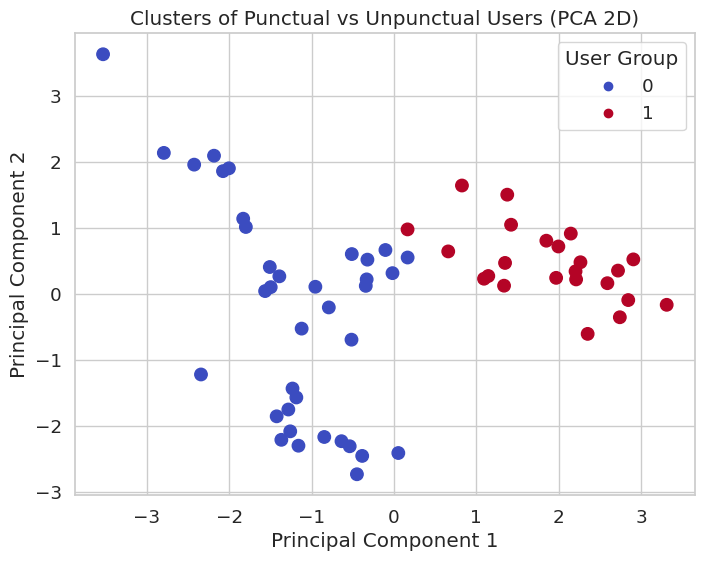

Clustering (punctual vs unpunctual) ✅
Assigned STD per group: {'punctual': 0.25, 'unpunctual': 0.75}


In [ ]:
# # EV Charging Planner: User Clustering with Realistic Punctuality Score and STD Assignment
#
# This notebook performs user clustering based on a realistic punctuality score, assigns a standard deviation (STD) of punctuality to each cluster, and visualizes the resulting clusters using PCA. The punctuality score is a weighted combination of stress index, driver age, and driver profession.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# =======================
# 1. Load CSV
# =======================
# Loads the vehicle data from a CSV file into a pandas DataFrame.
df = pd.read_csv("vehicles_precision_1.csv")

# =======================
# 2. Feature Engineering
# =======================
# Creates new features relevant for clustering and uncertainty assessment.
# - battery_level: Current charge normalized by battery capacity.
# - window_length: Duration of the available charging window.
# - required_energy: Energy needed to reach full charge.
# - required_time: Time needed to charge to full capacity.
# - stress_index: Ratio of required charging time to available window (higher indicates more stress/less flexibility).
# - time_of_day: Categorical representation of the start time (night, morning, afternoon, evening).
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

def map_time(hour):
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "evening"

df["time_of_day"] = df["available_time_start"].apply(map_time)

# =======================
# 3. Create punctuality score
# =======================
# Calculates a composite punctuality score based on stress index, driver age, and profession risk.
# Profession risk mapping (higher = more likely unpunctual)
profession_risk = {
    "student": 1.2,
    "unemployed": 1.3,
    "worker": 1.0,
    "retired": 0.9
}

# Age risk: younger = higher risk, normalize between 0.8-1.2
age_risk = 1.2 - 0.4 * (df["driver_age"] - df["driver_age"].min()) / (df["driver_age"].max() - df["driver_age"].min())

# Compute punctuality score
df["punctuality_score"] = (
    df["stress_index"] * 0.6 +  # main factor
    age_risk * 0.2 +
    df["driver_profession"].map(profession_risk) * 0.2
)

# Assign user_type based on score median
# Assigns a preliminary "user_type" (punctual/unpunctual) based on whether the punctuality score is above or below the median.
median_score = df["punctuality_score"].median()
df["user_type"] = np.where(df["punctuality_score"] > median_score, "unpunctual", "punctual")

# =======================
# 4. Prepare features for clustering
# =======================
# Selects features for clustering and applies one-hot encoding and standardization.
features = ["driver_age", "driver_profession", "use_frequency",
            "battery_level", "stress_index", "time_of_day", "origin_distance"]

X = df[features].copy()
encoder = OneHotEncoder(drop="first", sparse_output=False)
categorical = X[["driver_profession", "time_of_day"]]
encoded = encoder.fit_transform(categorical)
numeric = X.drop(columns=["driver_profession", "time_of_day"]).values
X_proc = np.hstack([numeric, encoded])
X_scaled = StandardScaler().fit_transform(X_proc)

# =======================
# 5. KMeans clustering (2 groups)
# =======================
# Performs KMeans clustering with 2 clusters.
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Map clusters to labels using the majority label in each cluster
# Assigns a label ("punctual" or "unpunctual") to each cluster based on the majority 'user_type' within that cluster.
cluster_map = {}
for c in df["cluster"].unique():
    majority_type = df[df["cluster"]==c]["user_type"].mode()[0]
    cluster_map[c] = majority_type
df["cluster_label"] = df["cluster"].map(cluster_map)

# =======================
# 6. Assign STD per group
# =======================
# Assigns predefined standard deviation (STD) values to the "punctual" and "unpunctual" cluster labels.
std_mapping = {"punctual": 0.25, "unpunctual": 0.75}
df["assigned_std"] = df["cluster_label"].map(std_mapping)

# =======================
# 7. PCA for visualization
# =======================
# Applies Principal Component Analysis (PCA) to reduce dimensionality for visualization and plots the two resulting clusters.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="coolwarm", s=80)
plt.title("Clusters of Punctual vs Unpunctual Users (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="User Group")
plt.grid(True)
plt.show()

# =======================
# 8. Save results
# =======================
# Saves the DataFrame with cluster assignments, cluster labels, and assigned STDs to a new CSV file.
df.to_csv("vehicles_punctuality_clusters_realistic.csv", index=False)
print("Clustering (punctual vs unpunctual) ✅")
print("Assigned STD per group:", std_mapping)

# Data Generation: Custom Synthetic Dataset for EV Charging Simulation

This notebook generates a custom synthetic dataset with a specified number of "punctual" and "unpunctual" users. The dataset includes various vehicle and driver attributes, as well as calculated features like stress index, designed for simulating and testing EV charging planning scenarios under different user behaviors.

In [ ]:
# # Data Generation: Custom Synthetic Dataset for EV Charging Simulation
#
# This notebook generates a custom synthetic dataset with a specified number of "punctual" and "unpunctual" users. The dataset includes various vehicle and driver attributes, as well as calculated features like stress index, designed for simulating and testing EV charging planning scenarios under different user behaviors.

import pandas as pd
import numpy as np

# Defines a function to generate a synthetic dataset with customizable numbers of punctual and unpunctual users.
def generate_custom_dataset(n_punctual=10, n_unpunctual=50, random_state=42):
    np.random.seed(random_state)

    total = n_punctual + n_unpunctual

    # -------------------
    # Driver attributes
    # -------------------
    # Generates synthetic data for driver attributes like age, profession, use frequency, and origin distance.
    professions = ["student", "unemployed", "worker", "retired"]
    ages = np.random.randint(18, 75, size=total)
    profession_choices = np.random.choice(professions, size=total)
    use_frequency = np.random.randint(1, 7, size=total)
    origin_distance = np.random.randint(5, 35, size=total)

    # -------------------
    # Battery & charging
    # -------------------
    # Generates synthetic data for vehicle battery capacity, charge speed, and initial current charge.
    battery_capacity = np.random.randint(80, 151, size=total)  # kWh
    charge_speed = np.random.randint(5, 15, size=total)  # kW
    current_charge = np.zeros(total)

    # -------------------
    # Window & stress
    # -------------------
    # Generates synthetic data for available charging time windows and calculates required charging time and stress index.
    # It differentiates between punctual and unpunctual users by assigning different window lengths and required times.
    available_time_start = np.random.randint(0, 24, size=total)
    window_length = np.zeros(total)

    # Punctual users
    window_length[:n_punctual] = np.random.randint(4, 10, size=n_punctual)
    required_time = np.random.randint(1, 4, size=n_punctual)
    current_charge[:n_punctual] = battery_capacity[:n_punctual] - required_time * charge_speed[:n_punctual]

    # Unpunctual users
    window_length[n_punctual:] = np.random.randint(1, 4, size=n_unpunctual)
    required_time_unp = np.random.randint(4, 8, size=n_unpunctual)
    current_charge[n_punctual:] = battery_capacity[n_punctual:] - required_time_unp * charge_speed[n_punctual:]

    available_time_end = available_time_start + window_length

    # -------------------
    # Build dataframe
    # -------------------
    # Constructs a pandas DataFrame from the generated data.
    df = pd.DataFrame({
        "driver_age": ages,
        "driver_profession": profession_choices,
        "use_frequency": use_frequency,
        "origin_distance": origin_distance,
        "battery_capacity": battery_capacity,
        "current_charge": current_charge,
        "charge_speed": charge_speed,
        "available_time_start": available_time_start,
        "available_time_end": available_time_end,
        "window_length": window_length  # ✅ add window_length
    })

    # Assign stress_index correctly
    # Calculates the stress index for both punctual and unpunctual users.
    df["stress_index"] = 0.0
    df.loc[:n_punctual-1, "stress_index"] = required_time / window_length[:n_punctual]
    df.loc[n_punctual:, "stress_index"] = required_time_unp / window_length[n_punctual:]

    # Assign user_type
    # Assigns the "punctual" or "unpunctual" label to each user.
    df["user_type"] = ["punctual"]*n_punctual + ["unpunctual"]*n_unpunctual


    return df

# Example usage
# Generates a custom dataset with 35 punctual and 25 unpunctual users and saves it to a CSV file.
df_custom = generate_custom_dataset(n_punctual=35, n_unpunctual=25)
df_custom.to_csv("vehicles_custom_dataset.csv", index=False)
print("Custom dataset generated ✅")
print(df_custom[["user_type", "stress_index", "window_length"]].head(10))

Custom dataset generated ✅
  user_type  stress_index  window_length
0  punctual      0.111111            9.0
1  punctual      0.111111            9.0
2  punctual      0.333333            6.0
3  punctual      0.285714            7.0
4  punctual      0.125000            8.0
5  punctual      0.750000            4.0
6  punctual      0.250000            8.0
7  punctual      0.285714            7.0
8  punctual      0.285714            7.0
9  punctual      0.142857            7.0


In [ ]:
import pandas as pd
import numpy as np

# =======================
# 1. Load original data
# =======================
df = pd.read_csv("vehicles_extended.csv")

# =======================
# 2. Feature engineering
# =======================
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

# =======================
# 3. Base grouping
# =======================
median_stress = df["stress_index"].median()
df["user_type"] = np.where(df["stress_index"] > median_stress, "unpunctual", "punctual")

# =======================
# 4. Generate 6 datasets with increasing separation
# =======================
np.random.seed(42)

# Noise levels for each dataset (higher = harder to classify)
noise_levels = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Separation factors for unpunctual users (higher = more distinct)
separation_factors = [1.0, 1.2, 1.5, 2.0, 3.0, 5.0]

for i in range(6):
    df_mod = df.copy()

    # Añadir ruido proporcional al nivel (más ruido = más difícil)
    noise = noise_levels[i]
    for col in ["current_charge", "charge_speed", "available_time_start", "available_time_end"]:
        scale = df_mod[col].std() * noise
        df_mod[col] += np.random.normal(0, scale, size=len(df_mod))

    # Recalcular dependientes
    df_mod["battery_level"] = df_mod["current_charge"] / df_mod["battery_capacity"]
    df_mod["window_length"] = df_mod["available_time_end"] - df_mod["available_time_start"]
    df_mod["required_energy"] = df_mod["battery_capacity"] - df_mod["current_charge"]
    df_mod["required_time"] = df_mod["required_energy"] / df_mod["charge_speed"]
    df_mod["stress_index"] = df_mod["required_time"] / df_mod["window_length"].replace(0, 0.5)

    # Aumentar diferencias de los usuarios impuntuales
    factor = separation_factors[i]
    df_mod.loc[df_mod["user_type"] == "unpunctual", "stress_index"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "required_time"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "window_length"] *= (1/factor)  # ventanas más ajustadas

    # Guardar CSV
    filename = f"vehicles_precision_{i+1}.csv"
    df_mod.to_csv(filename, index=False)
    print(f"✅ Saved {filename} (precision level {i+1})")

print("\nDatasets generated from level 1 (very mixed) to level 6 (super distinct).")


✅ Saved vehicles_precision_1.csv (precision level 1)
✅ Saved vehicles_precision_2.csv (precision level 2)
✅ Saved vehicles_precision_3.csv (precision level 3)
✅ Saved vehicles_precision_4.csv (precision level 4)
✅ Saved vehicles_precision_5.csv (precision level 5)
✅ Saved vehicles_precision_6.csv (precision level 6)

Datasets generated from level 1 (very mixed) to level 6 (super distinct).


In [ ]:
import pandas as pd
import numpy as np

# =======================
# 1. Load original data
# =======================
df = pd.read_csv("vehicles_extended.csv")

# =======================
# 2. Feature engineering
# =======================
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

# =======================
# 3. Base grouping (punctual vs unpunctual)
# =======================
median_stress = df["stress_index"].median()
df["user_type"] = np.where(df["stress_index"] > median_stress, "unpunctual", "punctual")

# =======================
# 4. Generate 6 datasets with increasing separation
# =======================
np.random.seed(42)

# Noise levels: higher = harder to classify
noise_levels = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

# Separation multipliers for unpunctuals (level 6 = super distinct)
separation_factors = [1.0, 1.5, 2.0, 3.0, 5.0, 10.0]

for i in range(6):
    df_mod = df.copy()

    # 1️⃣ Add random noise to numeric columns (higher noise = harder clustering)
    for col in ["current_charge", "charge_speed", "available_time_start", "available_time_end", "distance"]:
        scale = df_mod[col].std() * noise_levels[i]
        df_mod[col] += np.random.normal(0, scale, size=len(df_mod))

    # 2️⃣ Recalculate dependent features
    df_mod["battery_level"] = df_mod["current_charge"] / df_mod["battery_capacity"]
    df_mod["window_length"] = df_mod["available_time_end"] - df_mod["available_time_start"]
    df_mod["required_energy"] = df_mod["battery_capacity"] - df_mod["current_charge"]
    df_mod["required_time"] = df_mod["required_energy"] / df_mod["charge_speed"]
    df_mod["stress_index"] = df_mod["required_time"] / df_mod["window_length"].replace(0, 0.5)

    # 3️⃣ Apply strong separation for unpunctual users
    factor = separation_factors[i]
    df_mod.loc[df_mod["user_type"] == "unpunctual", "stress_index"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "required_time"] *= factor
    df_mod.loc[df_mod["user_type"] == "unpunctual", "window_length"] /= factor  # much tighter time windows
    df_mod.loc[df_mod["user_type"] == "unpunctual", "battery_level"] *= 0.9  # optional: lower charge

    # 4️⃣ Save dataset
    filename = f"vehicles_precision_{i+1}.csv"
    df_mod.to_csv(filename, index=False)
    print(f"✅ Saved {filename} (precision level {i+1})")

print("\nDatasets generated from level 1 (very mixed) to level 6 (super distinct).")


✅ Saved vehicles_precision_1.csv (precision level 1)
✅ Saved vehicles_precision_2.csv (precision level 2)
✅ Saved vehicles_precision_3.csv (precision level 3)
✅ Saved vehicles_precision_4.csv (precision level 4)
✅ Saved vehicles_precision_5.csv (precision level 5)
✅ Saved vehicles_precision_6.csv (precision level 6)

Datasets generated from level 1 (very mixed) to level 6 (super distinct).


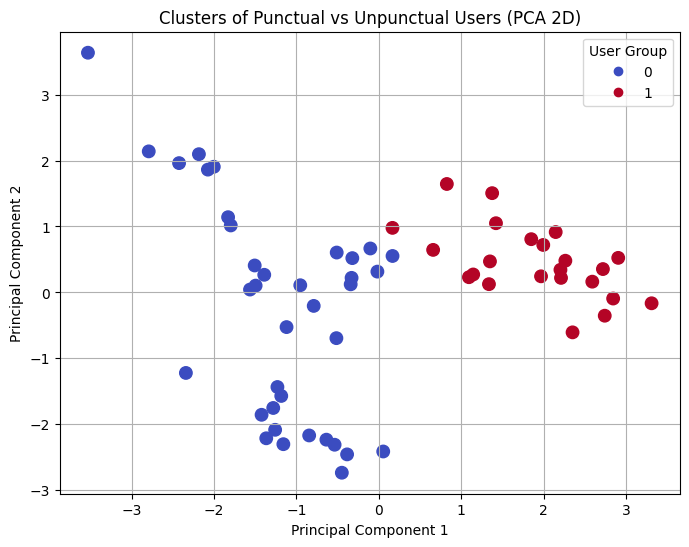

Clustering (punctual vs unpunctual) ✅
Assigned STD per group: {'punctual': 0.25, 'unpunctual': 0.75}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# =======================
# 1. Load CSV
# =======================
df = pd.read_csv("vehicles_precision_1.csv")

# =======================
# 2. Feature Engineering
# =======================
df["battery_level"] = df["current_charge"] / df["battery_capacity"]
df["window_length"] = df["available_time_end"] - df["available_time_start"]
df["required_energy"] = df["battery_capacity"] - df["current_charge"]
df["required_time"] = df["required_energy"] / df["charge_speed"]
df["stress_index"] = df["required_time"] / df["window_length"].replace(0, 0.5)

def map_time(hour):
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "evening"

df["time_of_day"] = df["available_time_start"].apply(map_time)

# =======================
# 3. Create punctuality score
# =======================
# Profession risk mapping (higher = more likely unpunctual)
profession_risk = {
    "student": 1.2,
    "unemployed": 1.3,
    "worker": 1.0,
    "retired": 0.9
}

# Age risk: younger = higher risk, normalize between 0.8-1.2
age_risk = 1.2 - 0.4 * (df["driver_age"] - df["driver_age"].min()) / (df["driver_age"].max() - df["driver_age"].min())

# Compute punctuality score
df["punctuality_score"] = (
    df["stress_index"] * 0.6 +  # main factor
    age_risk * 0.2 +
    df["driver_profession"].map(profession_risk) * 0.2
)

# Assign user_type based on score median
median_score = df["punctuality_score"].median()
df["user_type"] = np.where(df["punctuality_score"] > median_score, "unpunctual", "punctual")

# =======================
# 4. Prepare features for clustering
# =======================
features = ["driver_age", "driver_profession", "use_frequency",
            "battery_level", "stress_index", "time_of_day", "origin_distance"]

X = df[features].copy()
encoder = OneHotEncoder(drop="first", sparse_output=False)
categorical = X[["driver_profession", "time_of_day"]]
encoded = encoder.fit_transform(categorical)
numeric = X.drop(columns=["driver_profession", "time_of_day"]).values
X_proc = np.hstack([numeric, encoded])
X_scaled = StandardScaler().fit_transform(X_proc)

# =======================
# 5. KMeans clustering (2 groups)
# =======================
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Map clusters to labels using the majority label in each cluster
cluster_map = {}
for c in df["cluster"].unique():
    majority_type = df[df["cluster"]==c]["user_type"].mode()[0]
    cluster_map[c] = majority_type
df["cluster_label"] = df["cluster"].map(cluster_map)

# =======================
# 6. Assign STD per group
# =======================
std_mapping = {"punctual": 0.25, "unpunctual": 0.75}
df["assigned_std"] = df["cluster_label"].map(std_mapping)

# =======================
# 7. PCA for visualization
# =======================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="coolwarm", s=80)
plt.title("Clusters of Punctual vs Unpunctual Users (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="User Group")
plt.grid(True)
plt.show()

# =======================
# 8. Save results
# =======================
df.to_csv("vehicles_punctuality_clusters_realistic.csv", index=False)
print("Clustering (punctual vs unpunctual) ✅")
print("Assigned STD per group:", std_mapping)


In [ ]:
import pandas as pd
import numpy as np

def generate_custom_dataset(n_punctual=10, n_unpunctual=50, random_state=42):
    np.random.seed(random_state)

    total = n_punctual + n_unpunctual

    # -------------------
    # Driver attributes
    # -------------------
    professions = ["student", "unemployed", "worker", "retired"]
    ages = np.random.randint(18, 75, size=total)
    profession_choices = np.random.choice(professions, size=total)
    use_frequency = np.random.randint(1, 7, size=total)
    origin_distance = np.random.randint(5, 35, size=total)

    # -------------------
    # Battery & charging
    # -------------------
    battery_capacity = np.random.randint(80, 151, size=total)  # kWh
    charge_speed = np.random.randint(5, 15, size=total)  # kW
    current_charge = np.zeros(total)

    # -------------------
    # Window & stress
    # -------------------
    available_time_start = np.random.randint(0, 24, size=total)
    window_length = np.zeros(total)

    # Punctual users
    window_length[:n_punctual] = np.random.randint(4, 10, size=n_punctual)
    required_time = np.random.randint(1, 4, size=n_punctual)
    current_charge[:n_punctual] = battery_capacity[:n_punctual] - required_time * charge_speed[:n_punctual]

    # Unpunctual users
    window_length[n_punctual:] = np.random.randint(1, 4, size=n_unpunctual)
    required_time_unp = np.random.randint(4, 8, size=n_unpunctual)
    current_charge[n_punctual:] = battery_capacity[n_punctual:] - required_time_unp * charge_speed[n_punctual:]

    available_time_end = available_time_start + window_length

    # -------------------
    # Build dataframe
    # -------------------
    df = pd.DataFrame({
        "driver_age": ages,
        "driver_profession": profession_choices,
        "use_frequency": use_frequency,
        "origin_distance": origin_distance,
        "battery_capacity": battery_capacity,
        "current_charge": current_charge,
        "charge_speed": charge_speed,
        "available_time_start": available_time_start,
        "available_time_end": available_time_end,
        "window_length": window_length  # ✅ add window_length
    })

    # Assign stress_index correctly
    df["stress_index"] = 0.0
    df.loc[:n_punctual-1, "stress_index"] = required_time / window_length[:n_punctual]
    df.loc[n_punctual:, "stress_index"] = required_time_unp / window_length[n_punctual:]

    # Assign user_type
    df["user_type"] = ["punctual"]*n_punctual + ["unpunctual"]*n_unpunctual


    return df

# Example usage
df_custom = generate_custom_dataset(n_punctual=35, n_unpunctual=25)
df_custom.to_csv("vehicles_custom_dataset.csv", index=False)
print("Custom dataset generated ✅")
print(df_custom[["user_type", "stress_index", "window_length"]].head(10))


Custom dataset generated ✅
  user_type  stress_index  window_length
0  punctual      0.111111            9.0
1  punctual      0.111111            9.0
2  punctual      0.333333            6.0
3  punctual      0.285714            7.0
4  punctual      0.125000            8.0
5  punctual      0.750000            4.0
6  punctual      0.250000            8.0
7  punctual      0.285714            7.0
8  punctual      0.285714            7.0
9  punctual      0.142857            7.0
